## imports lib

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# data analysis and wrangling
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
from ipywidgets import interact
import joblib
import shap
shap.initjs()
import warnings
import lightgbm as lgb
import pickle
# machine learning 
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,classification_report,make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance 
import MyClassAndFun as MCF

## import data

In [3]:
X_train_df=pd.read_csv('X_train.csv')
X_test_df=pd.read_csv('X_test.csv')
y_train=pd.read_csv('y_train.csv')
y_train = y_train['credit_score'] 
y_test=pd.read_csv('y_test.csv')
y_test = y_test['credit_score'] 
Random_Forest_C = joblib.load('random_forest_model.joblib')
Random_Forest_pred = Random_Forest_C.predict(X_test_df)
confusion = confusion_matrix(y_test, Random_Forest_pred)
report = classification_report(y_test, Random_Forest_pred)
cm = confusion_matrix(y_test, Random_Forest_pred)
cm_norm = confusion_matrix(y_test, Random_Forest_pred, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

# SHAP

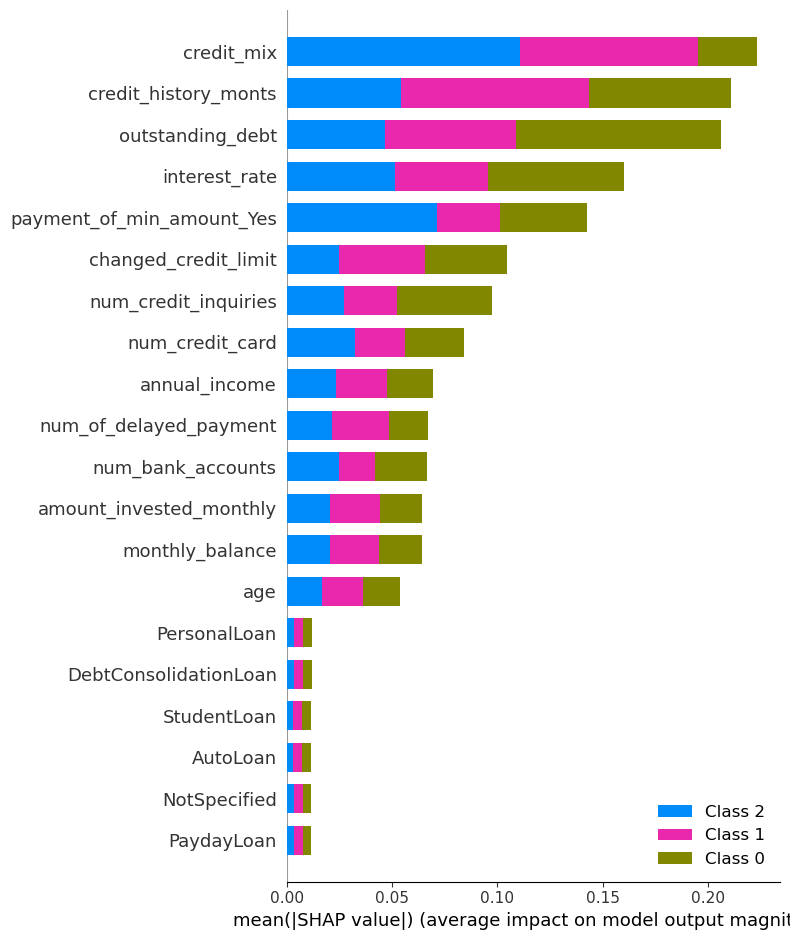

In [4]:
explainer = shap.TreeExplainer(Random_Forest_C)
shap_values = explainer.shap_values(X_test_df, approximate=True)
shap.summary_plot(shap_values,X_test_df )

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1])


shap.plots.force is slow for many thousands of rows, try subsampling your data.


In [ ]:
shap.force_plot(explainer.expected_value[2], shap_values[2])

## Predict 0 Actual 2

In [ ]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [6]:
# y_test_reset_index = y_test.reset_index(drop=True)
# Random_Forest_pred_series = pd.Series(Random_Forest_pred)
# Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# # Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
# comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# # Displaying a few rows to check
# # print(comparison_df.head())
# index_A2_P0=comparison_df.loc[(comparison_df['True_Values'] == 2) & (comparison_df['Predicted_Values'] == 0),'Index']
# X_A2_P0 = X_test_df.loc[index_A2_P0]
# shap_values_A2_P0 = explainer.shap_values(X_A2_P0, approximate=True)
# for i in [0,2]:
#     shap.decision_plot(explainer.expected_value[1], shap_values_A2_P0[i], X_A2_P0.columns,ignore_warnings=True)
#     plt.title("shap for"+i)


## Predict 2 Actual 0

In [ ]:
# y_test_reset_index = y_test.reset_index(drop=True)
# Random_Forest_pred_series = pd.Series(Random_Forest_pred)
# Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# # Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
# comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# # Displaying a few rows to check
# index_A0_P2=comparison_df.loc[(comparison_df['True_Values'] == 0) & (comparison_df['Predicted_Values'] == 2),'Index']
# X_A0_P2 = X_test_df.loc[index_A0_P2]
# shap_values_A0_P2 = explainer.shap_values(X_A0_P2, approximate=True)
# for i in [0,2]:
#     shap.decision_plot(explainer.expected_value[1], shap_values_A0_P2[i], X_A0_P2.columns,ignore_warnings=True)

## Predict 2 Actual 1

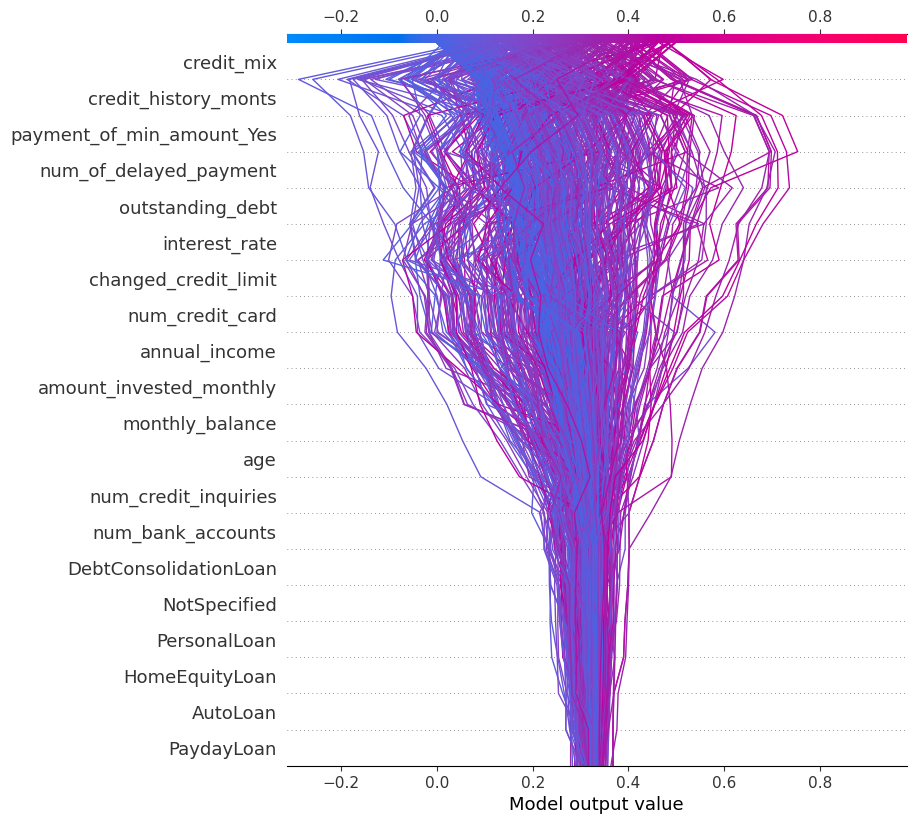

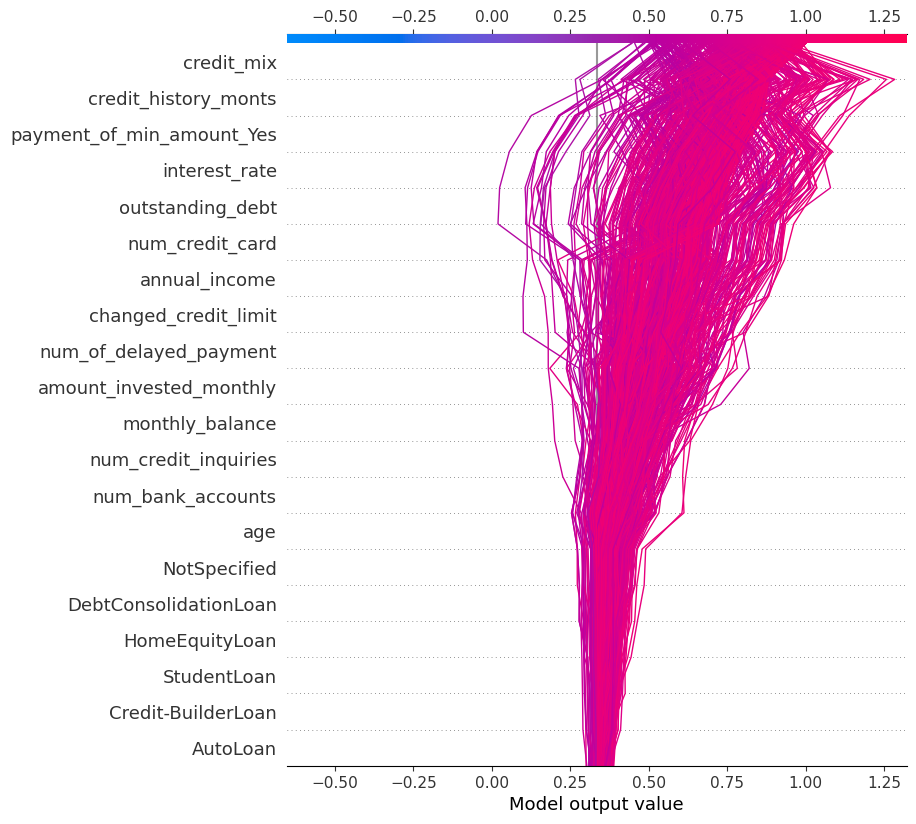

In [7]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A1_P2=comparison_df.loc[(comparison_df['True_Values'] ==1) & (comparison_df['Predicted_Values'] == 2),'Index']
X_A1_P2 = X_test_df.loc[index_A1_P2]
shap_values_A1_P2 = explainer.shap_values(X_A1_P2, approximate=True)
for i in [1,2]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A1_P2[i], X_A1_P2.columns,ignore_warnings=True)
    

## Predict 0 Actual 1

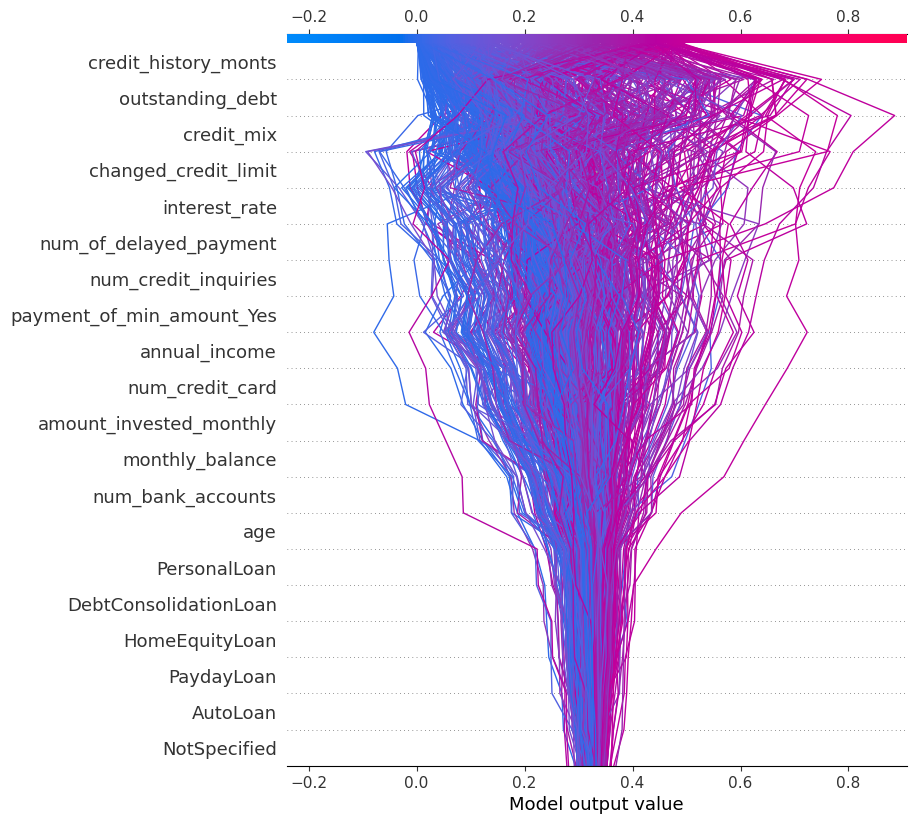

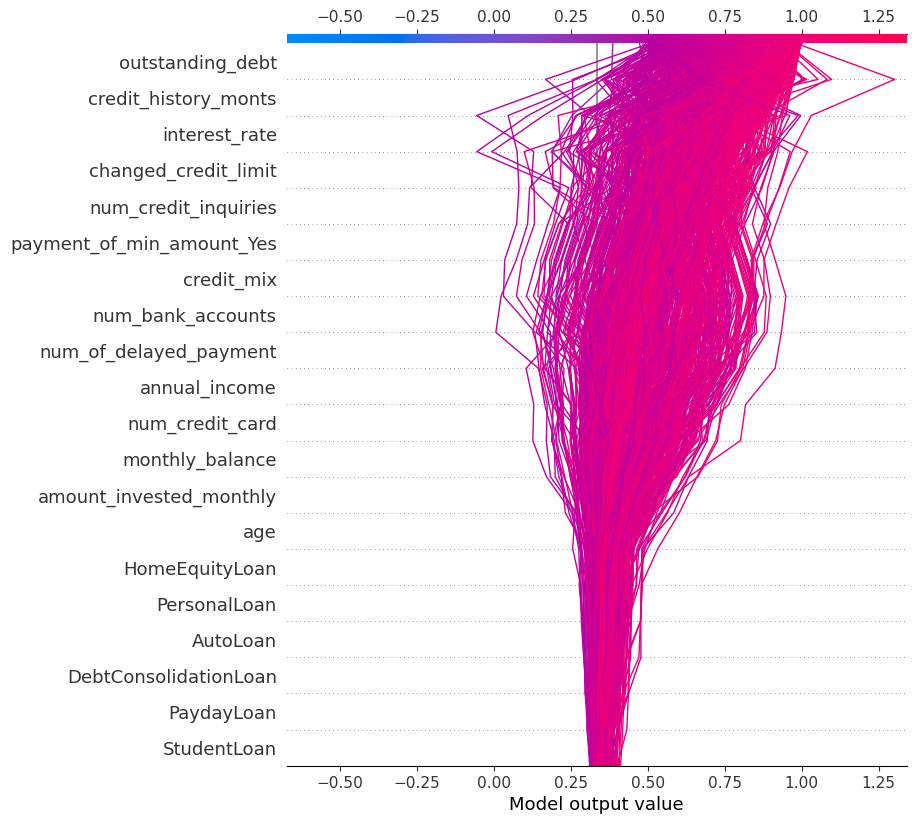

In [8]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A1_P0=comparison_df.loc[(comparison_df['True_Values'] ==1) & (comparison_df['Predicted_Values'] == 0),'Index']
X_A1_P0 = X_test_df.loc[index_A1_P0]
shap_values_A1_P0 = explainer.shap_values(X_A1_P0, approximate=True)
for i in [1,0]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A1_P0[i], X_A1_P0.columns,ignore_warnings=True)

## Predict 1 Actual 0

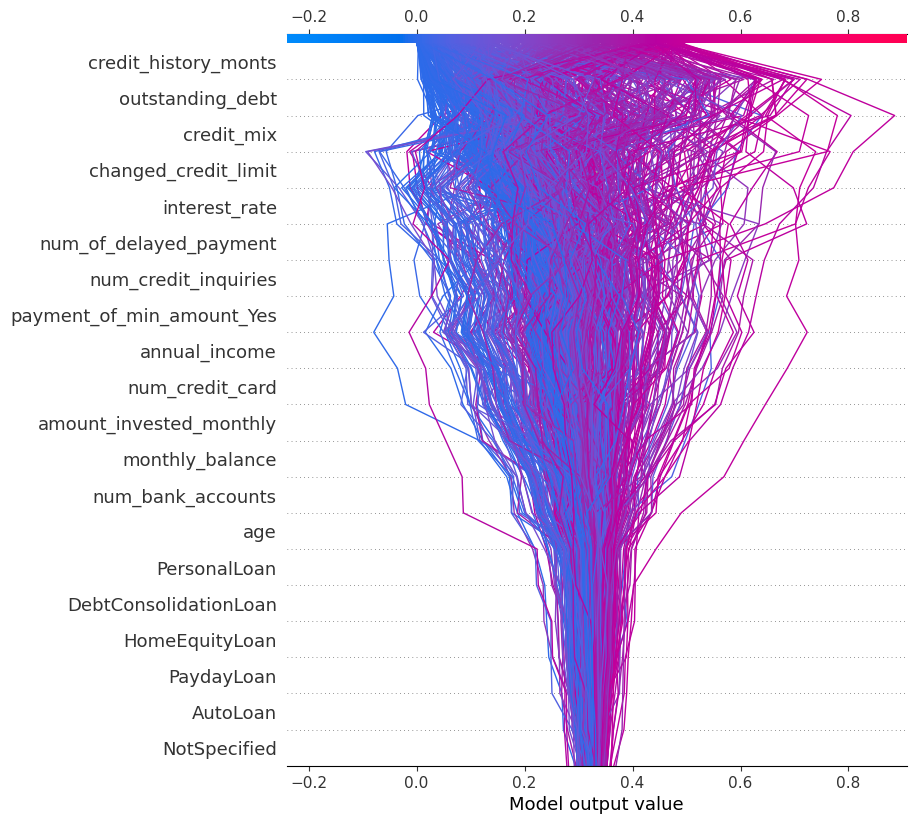

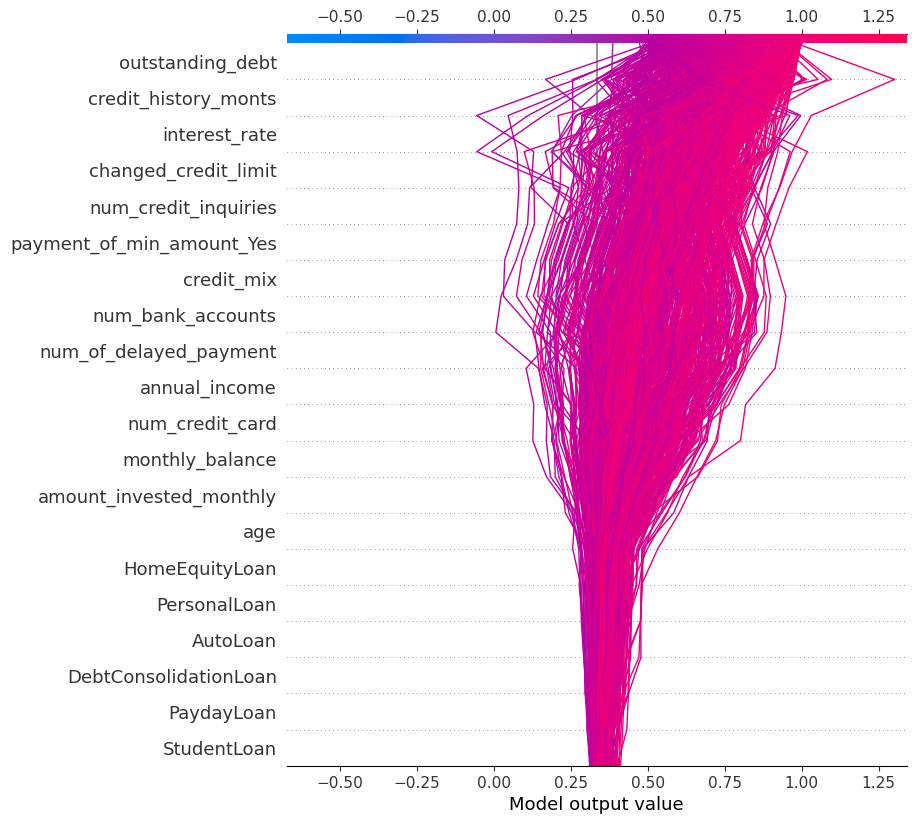

In [9]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A0_P1=comparison_df.loc[(comparison_df['True_Values'] ==0) & (comparison_df['Predicted_Values'] == 1),'Index']
X_A0_P1 = X_test_df.loc[index_A0_P1]
shap_values_A0_P1 = explainer.shap_values(X_A1_P0, approximate=True)
for i in [1,0]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A0_P1[i], X_A0_P1.columns,ignore_warnings=True)

## Predict 1 Actual 2

In [ ]:
y_test_reset_index = y_test.reset_index(drop=True)
Random_Forest_pred_series = pd.Series(Random_Forest_pred)
Random_Forest_pred_series_reset_index = Random_Forest_pred_series.reset_index(drop=True)
# Creating a DataFrame with aligned true and predicted values, preserving the indices from y_test
comparison_df = pd.DataFrame({'Index': y_test.index, 'True_Values': y_test_reset_index, 'Predicted_Values': Random_Forest_pred_series_reset_index})
# Displaying a few rows to check
index_A0_P1=comparison_df.loc[(comparison_df['True_Values'] ==2) & (comparison_df['Predicted_Values'] == 1),'Index']
X_A0_P1 = X_test_df.loc[index_A0_P1]
shap_values_A0_P1 = explainer.shap_values(X_A1_P0, approximate=True)
for i in [1,2]:
    shap.decision_plot(explainer.expected_value[1], shap_values_A0_P1[i], X_A0_P1.columns,ignore_warnings=True)